In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import tqdm

import celltrip


# Load Data and Policy

In [3]:
# Load train and validation data
adatas_train = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_expression.h5ad',
    's3://nkalafut-celltrip/Cortex/brain_st_cortex_spatial.h5ad',
    backed=True)
adata_val, = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/Cortex/brain_sc_expression.h5ad',
    backed=True)
# Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250919', 800  # On lognorm data from authors
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250922', 800  # Raw data - best so far
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251013', 800  # Raw data - 32 dim - USING
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251022', 800  # MSE + PAIR - 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251023-cont', 1050  # MSE, 1024 PCA - 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251024', 800  # MSE, 2048 PCA - 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-251024-2', 800  # MSE, 1024 PCA - 32 dim
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Create sample env (kind of a dumb workaround, TODO)
m1, m2 = [preprocessing.transform(ad[:2].X, subset_modality=i)[0] for i, ad in enumerate(adatas_train)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # , pinning_spatial=[1]
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
# Load expression data
train_exp = adatas_train[0].X[:]
val_exp = adata_val.X[:]

# Scale with mean and std
# train_exp_log = np.log1p(train_exp)
# val_exp_log = np.log1p(val_exp)
# val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0)) / val_exp_log.std(keepdims=True, axis=0)
# val_exp_log_corrected = val_exp_log_norm * train_exp_log.std(keepdims=True, axis=0) + train_exp_log.mean(keepdims=True, axis=0)
# val_exp_log_corrected = np.nan_to_num(val_exp_log_corrected)
# val_exp_corrected = np.expm1(val_exp_log_corrected)
# val_exp_corrected = val_exp_corrected * 10_000 / val_exp_corrected.sum(keepdims=True, axis=1)

# Scale with mean
train_exp_log = np.log1p(train_exp)
val_exp_log = np.log1p(val_exp)
val_exp_log_norm = (val_exp_log - val_exp_log.mean(keepdims=True, axis=0))
val_exp_log_corrected = val_exp_log_norm + train_exp_log.mean(keepdims=True, axis=0)
val_exp_log_corrected = np.nan_to_num(val_exp_log_corrected)
val_exp_corrected = np.expm1(val_exp_log_corrected)
val_exp_corrected[val_exp_corrected < 0] = 0
val_exp_corrected = val_exp_corrected * 10_000 / val_exp_corrected.sum(keepdims=True, axis=1)

# Visualize differences
# import umap
# red = umap.UMAP()  # random_state=42
# train_red = red.fit_transform(train_exp)
# val_red = red.transform(val_exp)
# val_corr_red = red.transform(val_exp_corrected)
# plt.scatter(*train_red.T)
# plt.scatter(*val_red.T)
# plt.scatter(*val_corr_red.T)

# Generate Steady State

In [5]:
## Run on training data
# Initialize validation environment
m1, = preprocessing.transform(train_exp, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state_train = ret[-1][-1, :, :env.dim]
# target_state = env.modalities[env.target_modalities[0]].cpu()
with torch.no_grad():
    imputed_steady_state_train = policy.pinning[0](steady_state_train.to('cuda')).detach().cpu().numpy()  # , Y=target_state.to('cuda')
imputed_steady_state_train, = preprocessing.inverse_transform(imputed_steady_state_train, subset_modality=1)

# Save
np.save(f'../plots/cortex/CellTRIP_Training.npy', imputed_steady_state_train)


1281it [00:12, 103.33it/s]


In [6]:
## Run on validation data
# Initialize validation environment
# m1, = preprocessing.transform(val_exp, subset_modality=0)
m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1, :, :env.dim]
# target_state = env.modalities[env.target_modalities[0]].cpu()
with torch.no_grad():
    imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()  # , Y=target_state.to('cuda')
imputed_steady_state, = preprocessing.inverse_transform(imputed_steady_state, subset_modality=1)

# Use OT to match distributions
a, b, M_raw, OT_mat = celltrip.utility.general.compute_discrete_ot_matrix(imputed_steady_state, adatas_train[1].X[:])
max_idx = OT_mat.argmax(axis=1)
imputed_steady_state_OT = adatas_train[1].X[:][max_idx]
cost = M_raw[np.arange(M_raw.shape[0]), max_idx]

# Match distribution means
diff = adatas_train[1].X[:].mean(axis=0) - imputed_steady_state.mean(axis=0)

# Warp data to match distribution
train_spat = adatas_train[1].X[:]
imputed_steady_state_warp = (imputed_steady_state - imputed_steady_state.mean(keepdims=True, axis=0)) / imputed_steady_state.std(keepdims=True, axis=0)
imputed_steady_state_warp = (imputed_steady_state_warp * train_spat.std(keepdims=True, axis=0) + train_spat.mean(keepdims=True, axis=0))

# Filters
manual_mask = (imputed_steady_state[:, 1]<7000) * (imputed_steady_state[:, 1]>5000)  # Manual
cost_mask = cost < np.quantile(cost, .5)  # Cost
close_mask = scipy.spatial.distance_matrix(imputed_steady_state, adatas_train[1].X[:]).min(axis=1) < 100  # Distance from training

# Save
np.save(f'../plots/cortex/CellTRIP_Validation.npy', imputed_steady_state)
np.save(f'../plots/cortex/CellTRIP_Diff_Validation.npy', imputed_steady_state+diff)
np.save(f'../plots/cortex/CellTRIP-OT_Validation.npy', imputed_steady_state_OT)
np.save(f'../plots/cortex/CellTRIP-Warp_Validation.npy', imputed_steady_state_warp)
# Filters
np.save(f'../plots/cortex/CellTRIP-Manual_Mask.npy', cost_mask)
np.save(f'../plots/cortex/CellTRIP-Cost_Mask.npy', cost_mask)
np.save(f'../plots/cortex/CellTRIP-Close_Mask.npy', close_mask)


1281it [00:31, 41.07it/s]


## Preview

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sklearn.neighbors

In [65]:
# Load additional methods
cytospace_df = pd.read_csv(f'../plots/cortex/Cytospace_Validation.csv')
cytospace_mask = np.isin(adata_val.obs.index, cytospace_df['OriginalCID'])
celltrek_df = pd.read_csv(f'../plots/cortex/CellTREK_Validation.csv', index_col=0)
celltrek_mask = np.isin(adata_val.obs.index, celltrek_df.index)
ground_truth_df = pd.read_csv(f'../plots/cortex/Groundtruth_Validation.csv')

# Params
cluster_order = np.array([5, 2, 7, 1, 4, 6])
layer_order = np.array(['L1', 'L2/3', 'L4', 'L5', 'L6', 'L6b'])
subclass_order = np.array(['Astro', 'Vip', 'Lamp5', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'NP', 'Pvalb', 'Sst', 'L6 IT', 'L6b'])
subclass_order = np.array(['Astro', 'Endo', 'Vip', 'Lamp5', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'NP', 'Pvalb', 'Sncg', 'Sst', 'L6 IT', 'L6 CT', 'L6b'])

In [66]:
# Layer score prediction based on training
layer_scores_knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=1_000, weights='distance')
layer_scores_knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'].replace({k: v for k, v in zip(cluster_order, range(6))}));

# Layer score prediction based on imputed
layer_scores_train_knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=200, weights='uniform')
layer_scores_train_knn.fit(imputed_steady_state_train, adatas_train[1].obs['seurat_clusters'].replace({k: v for k, v in zip(cluster_order, range(6))}))

KNeighborsRegressor(n_neighbors=200)

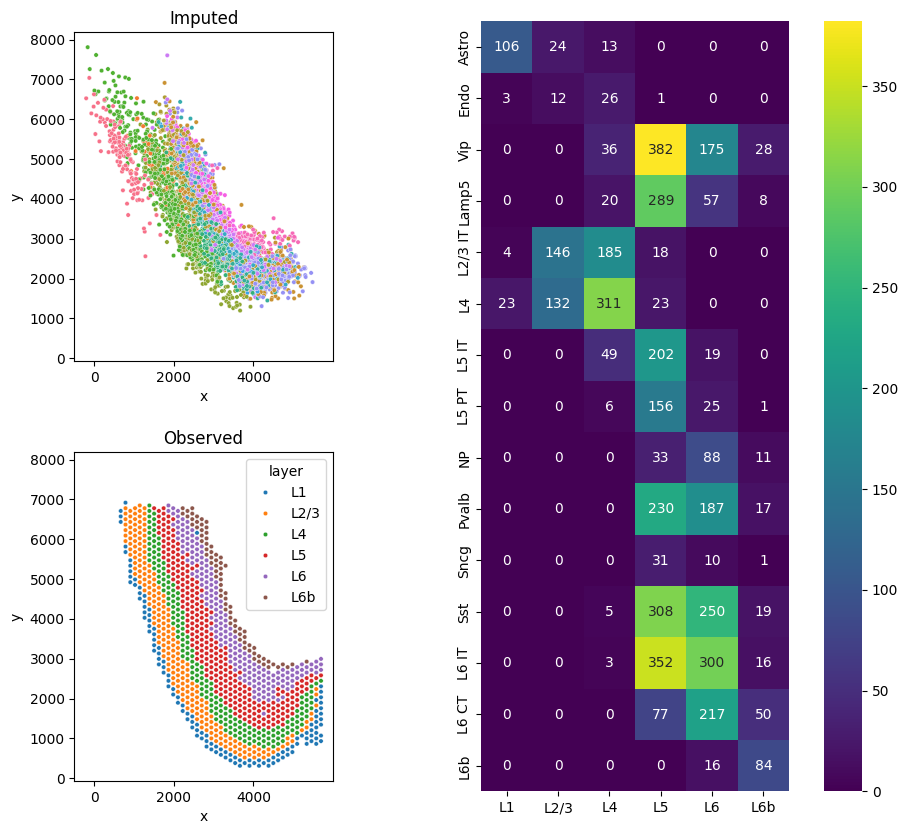

In [67]:
# Format true data
df_true = pd.DataFrame(index=adatas_train[1].obs.index)
df_true[['x', 'y']] = adatas_train[1].X[:]
df_true['cluster'] = adatas_train[1].obs['seurat_clusters']
df_true['layer'] = df_true['cluster'].replace({k: v for k, v in zip(cluster_order, layer_order)})

# Get imputed df
df_impute = pd.DataFrame(index=adata_val.obs.index)
imputed_to_use = imputed_steady_state
# imputed_to_use = imputed_steady_state + diff
# imputed_to_use = imputed_steady_state_OT
# imputed_to_use = imputed_steady_state_warp
# imputed_to_use = imputed_steady_state_expand
df_impute[['x', 'y']] = imputed_to_use
df_impute['subclass'] = adata_val.obs['subclass']

# Layer prediction by nearest in training
# knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance')
# knn.fit(adatas_train[1].X[:], adatas_train[1].obs['seurat_clusters'])
# layers = knn.predict(imputed_to_use)
# df_impute['layer'] = layers

# Layer prediction by nearest predicted score
df = pd.DataFrame({
    'Layer': adatas_train[1].obs['seurat_clusters'],
    'Score': layer_scores_train_knn.predict(imputed_steady_state_train)})
df_grouped = pd.concat([
    df.groupby('Layer').mean().rename(columns={'Score': 'Mean'}),
    df.groupby('Layer').std().rename(columns={'Score': 'STD'}),
    df.groupby('Layer').median().rename(columns={'Score': 'Median'}),
    df.groupby('Layer').agg(scipy.stats.iqr).rename(columns={'Score': 'IQR'}),
    df.groupby('Layer').size().to_frame('Percentage')], axis=1).reset_index()
df_grouped['Percentage'] /= df_grouped['Percentage'].sum()
mean_dist = layer_scores_train_knn.predict(imputed_to_use).reshape((1, -1)) - df_grouped[['Mean']].to_numpy()
z_scores = mean_dist / df_grouped[['STD']].to_numpy()
median_dist = layer_scores_train_knn.predict(imputed_to_use).reshape((1, -1)) - df_grouped[['Median']].to_numpy()
median_z_dist = median_dist / df_grouped[['IQR']].to_numpy()
# val_layers = df_grouped['Layer'].iloc[np.abs(mean_dist).argmin(axis=0)].to_numpy()
# val_layers = df_grouped['Layer'].iloc[np.abs(z_scores).argmin(axis=0)].to_numpy()
# val_layers = df_grouped['Layer'].iloc[np.abs(median_dist).argmin(axis=0)].to_numpy()
layers = df_grouped['Layer'].iloc[np.abs(median_z_dist).argmin(axis=0)].to_numpy()
# df_grouped.sort_values('Mean')
df_impute['layer'] = layers

# Filter
# mask = close_mask
# mask = scipy.spatial.distance_matrix(imputed_to_use, adatas_train[1].X[:]).min(axis=1) < 500
# mask = cytospace_mask
# mask = celltrek_mask
mask = slice(None)
df_impute = df_impute.loc[mask]
# Construct heatmap
pivot_df = (
    df_impute.groupby(['subclass', 'layer'], observed=False).size()
    .reset_index(name='Count')
    .pivot(index='subclass', columns='layer', values='Count'))
pivot_df = pivot_df.fillna(0)
try:
    pivot_df = pivot_df.loc[subclass_order, cluster_order]
    pivot_df.columns = layer_order
except: pass

# Scatter
fig = plt.figure(figsize=(11, 10))
gs = mpl.gridspec.GridSpec(2, 2, fig, width_ratios=[3, 8], wspace=-.2)
ax_impute = fig.add_subplot(gs[0, 0])
ax_true = fig.add_subplot(gs[1, 0], sharex=ax_impute, sharey=ax_impute)
ax_heat = fig.add_subplot(gs[:, 1])

# Imputed and true
sns.scatterplot(df_impute, x='x', y='y', hue='subclass', hue_order=subclass_order, s=10., legend=False, ax=ax_impute)
ax_impute.set_title('Imputed')
ax_impute.set_aspect('equal')
# axs[0].set(xlim=[500, 6_000], ylim=[0, 7_000])
sns.scatterplot(df_true, x='x', y='y', hue='layer', hue_order=layer_order, s=10., ax=ax_true)
ax_true.set_title('Observed')
ax_true.set_aspect('equal')

# Heatmap
# pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)  # Row normalize
# sns.heatmap(pivot_df, annot=False, fmt='.0f', cmap='Blues', cbar=False, ax=ax_heat)
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='viridis', ax=ax_heat)
ax_heat.set_ylabel(None)
ax_heat.set_aspect('equal')


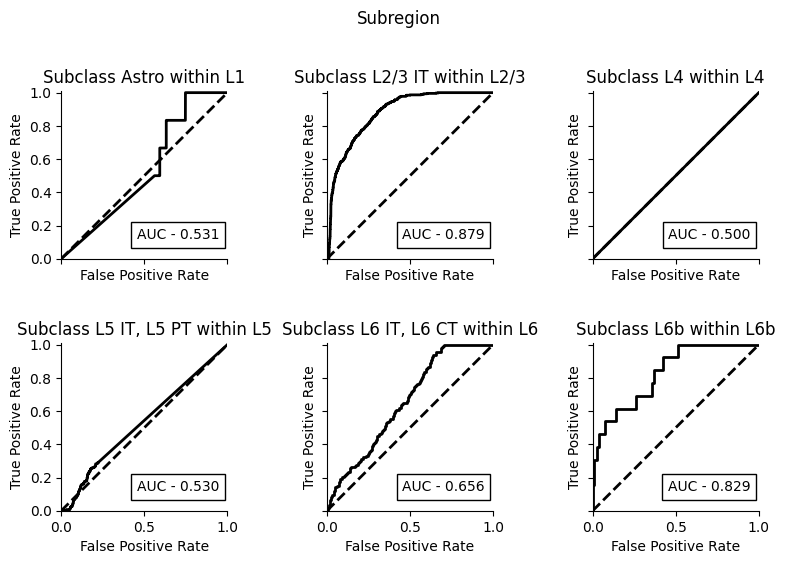

In [ ]:
# Combinations
combinations = [
    ('L1', ['Astro']),
    ('L2/3', ['L2/3 IT']),
    ('L4', ['L4']),
    ('L5', ['L5 IT', 'L5 PT']),
    ('L6', ['L6 IT', 'L6 CT']),
    ('L6b', ['L6b'])]

# Create figure
fig, axs = plt.subplots(
    2, 3,
    sharex=True, sharey=True,
    figsize=(3*3, 2*3))
axs = axs.flatten()
fig.subplots_adjust(wspace=.6)

for ax, (layer, subclass) in zip(axs, combinations):
    # Define targets
    cluster_idx = cluster_order[np.argmax(layer_order==layer)]
    y_train = adatas_train[1].obs['seurat_clusters'] == cluster_idx
    y_val = np.isin(adata_val.obs['subclass'], subclass)
    X_train = adatas_train[1].X[:]
    # X_train = imputed_steady_state_train

    # Get evaluation data
    # Subregion
    fig.suptitle('Subregion')
    X_val = ground_truth_df[['x', 'y']].to_numpy()
    y_val = np.isin(ground_truth_df['subclass'], subclass)
    # CellTRIP
    # fig.suptitle('CellTRIP')
    # X_val = imputed_to_use
    # CellTREK
    # fig.suptitle('CellTREK')
    # X_val = celltrek_df[['x', 'y']].to_numpy()
    # y_val = np.isin(adata_val.obs.loc[celltrek_df.index, 'subclass'], subclass)
    # Cytospace
    # fig.suptitle('Cytospace')
    # X_val = cytospace_df[['x', 'y']].to_numpy()
    # y_val = np.isin(adata_val.obs.loc[cytospace_df['OriginalCID'], 'subclass'], subclass)

    # Train SVC
    svc = sklearn.svm.SVC(probability=True).fit(X_train, y_train)
    y_val_pred = svc.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_val, y_val_pred)
    auc = sklearn.metrics.auc(fpr, tpr)

    # Plot
    ax.plot(fpr, tpr, lw=2, color='black')
    ax.plot([0, 1], [0, 1], ls='--', lw=2, color='black')
    ax.set(xlim=[0, 1], ylim=[0, 1.01])
    ax.set(
        title=f'Subclass {", ".join(subclass)} within {layer}',
        xlabel='False Positive Rate',
        ylabel='True Positive Rate')
    ax.text(
        .95, .1, f'AUC - {auc:.3f}',
        ha='right', va='bottom', 
        bbox=dict(facecolor='white', edgecolor='black'),
        transform=ax.transAxes)
    ax.set_aspect('equal')
    sns.despine(ax=ax)

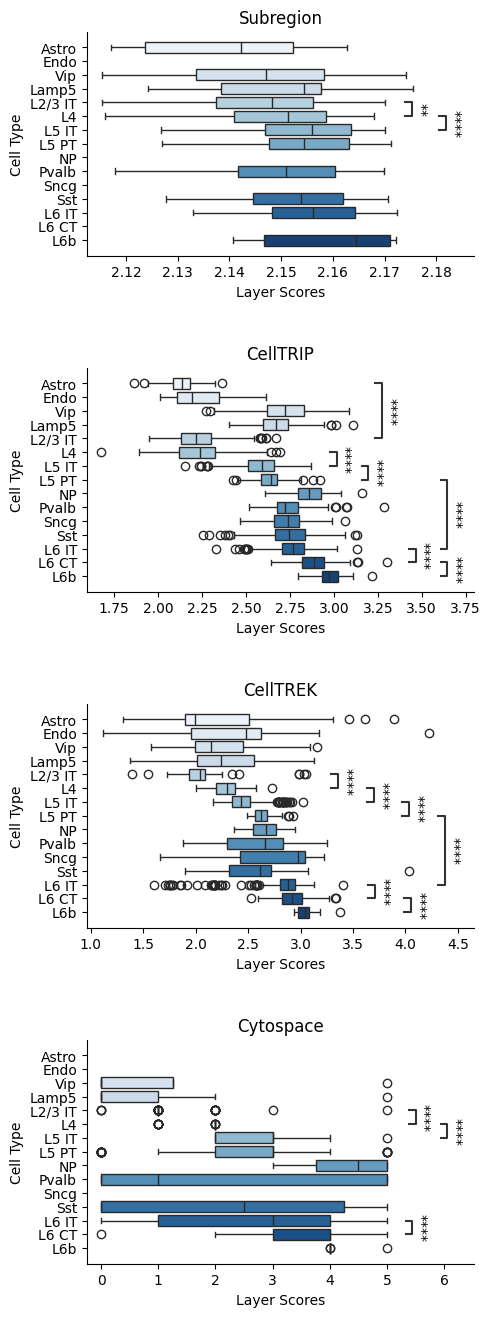

In [76]:
# Plot
perf_runs = [
    {   'name': 'Subregion',
        'cell_types': ground_truth_df['subclass'],
        'imputed_to_use': ground_truth_df[['x', 'y']].to_numpy()},
    {   'name': 'CellTRIP',
        'cells_to_use': adata_val.obs.index[mask],
        'imputed_to_use': imputed_steady_state[mask]},
    {   'name': 'CellTREK',
        'cells_to_use': celltrek_df.index,
        'imputed_to_use': celltrek_df[['x', 'y']].to_numpy()},
    {   'name': 'Cytospace',
        'cells_to_use': cytospace_df['OriginalCID'],
        'imputed_to_use': cytospace_df[['x', 'y']].to_numpy()}]
fig, axs = plt.subplots(len(perf_runs), 1, figsize=(5, 4*len(perf_runs)), sharex=False, sharey=True)
fig.subplots_adjust(hspace=.5)
for perf_run, ax in zip(perf_runs, axs):
    # Get data
    layer_scores = layer_scores_knn.predict(perf_run['imputed_to_use'])

    # Parameters
    assert ('cells_to_use' in perf_run) or ('cell_types' in perf_run)
    if 'cells_to_use' not in perf_run:
        cell_types = perf_run['cell_types']
        cells_to_use = np.arange(cell_types.shape[0])
    if 'cell_types' not in perf_run:
        cells_to_use = perf_run['cells_to_use']
        cell_types = adata_val[cells_to_use].obs['subclass']

    # Format data
    df_impute = pd.DataFrame(index=cells_to_use)
    df_impute['Cell Type'] = cell_types
    ct_nums = {k: v for v, k in enumerate(subclass_order)}
    df_impute['Cell Type Number'] = df_impute['Cell Type'].astype(str).apply(lambda s: ct_nums[s] if s in ct_nums else -1)
    df_impute['Layer Scores'] = layer_scores
    cell_means = df_impute[['Cell Type', 'Layer Scores']].groupby('Cell Type', observed=False).mean()
    df_impute['Mean Diff'] = df_impute['Layer Scores'] - df_impute['Cell Type'].apply(lambda s: cell_means.loc[s, 'Layer Scores']).astype(float)
    df_impute['Mean Diff'] = df_impute['Mean Diff'].abs()

    # Get correlation
    df_impute_filt = df_impute.loc[df_impute['Cell Type Number'] != -1]
    correlation_result = scipy.stats.pearsonr(df_impute_filt['Cell Type Number'], df_impute_filt['Layer Scores'])

    # Plot
    df = df_impute.reset_index()
    sns.boxplot(
        df, x='Layer Scores', y='Cell Type', orient='h', order=subclass_order,
        hue='Cell Type', hue_order=subclass_order, palette='Blues', ax=ax)
    sns.despine(ax=ax)
    ax.set_title(perf_run['name'])

    # Correlation annotation
    # ax.text(
    #     1., 1.12, f'pearson={correlation_result.statistic:.3f}\np={correlation_result.pvalue:.2e}',
    #     ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black'), transform=ax.transAxes)
    
    # Annotations
    from statannotations.Annotator import Annotator
    # Append dummy data for missing CTs to appease statannotations
    df_use = df.copy()
    for sc in subclass_order:
        if sc not in df['Cell Type'].unique():
            df_dummy = df_use.iloc[:2].copy()
            df_dummy['Cell Type'] = sc
            df_use = pd.concat([df_use, df_dummy], axis=0)

    pairs = [
        ('Astro', 'L2/3 IT'), ('L2/3 IT', 'L4'), ('L4', 'L5 IT'),
        ('L5 IT', 'L5 PT'), ('L5 PT', 'L6 IT'), ('L6 IT', 'L6 CT'),
        ('L6 CT', 'L6b')]
    annotator = Annotator(ax, pairs, data=df_use, x='Layer Scores', y='Cell Type', orient='h', order=subclass_order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True, verbose=False)
    annotator.apply_and_annotate()

In [12]:
assert False

AssertionError: 

# Perform Perturbation Prediction

In [ ]:
# Params
np.random.seed(42)
adatas = [adata_val]
# genes_to_survey = np.random.choice(adatas[0].var_names, 2_000, replace=False)
assert preprocessing.filter_mask[0] is None
genes_to_survey = adatas[0].var_names[preprocessing.standardize_std[0].flatten().argsort()[::-1]][:2000]  # 2k hvg
sim_time = 1.

# Mute warnings (array wrap and indexing)
import warnings
warnings.simplefilter('ignore')

# Create anndata
ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
def add_layers(states, gene):
    ad_pert.layers[gene] = states

# Add results
results = []
def add_record(states, states_0, gene, ct):
    results.append({
        'Gene': gene, 'Cell Type': ct,
        'Effect Size (Latent)': np.square(states[-1] - states[0]).mean(),
        'Trajectory Length (Latent)': np.square(states[1:] - states[:-1]).mean(axis=(-2, -1)).sum(),
        'Effect Size (Spatial)': np.square(states_0[-1] - states_0[0]).mean(),
        'Trajectory Length (Spatial)': np.square(states_0[1:] - states_0[:-1]).mean(axis=(-2, -1)).sum()})
    
# Reset function
def reset_env(env, steady_pos, steady_vel, modal_dict={}):
    env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
    env.set_positions(steady_pos)
    env.set_velocities(steady_vel)  # Maybe 0 manually?
    for k, v in modal_dict.items():
        env.modalities[k] = v

# Running function
def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
    # Run and impute
    states = celltrip.train.simulate_until_completion(
        env, policy,
        env_hooks=[
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            # celltrip.utility.hooks.move_toward_targets_hook(
            #     gene_idx, feature_targets=0., pinning=policy.pinning[0],
            #     preprocessing=preprocessing, modality_idx=0,
            #     factor=1, device=env.device),
        ],
        skip_states=100, store_states='cpu')[-1]
    states_pos = states[..., :env.dim]
    with torch.no_grad():
        imputed_states_1 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
    imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
    # Record
    add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
    add_record(states_pos.numpy(), imputed_states_1, gene, 'All')
    for ct in adatas[0][samples].obs['subclass'].unique():
        add_record(
            states_pos[:, adatas[0][samples].obs['subclass']==ct].numpy(),
            imputed_states_1[:, adatas[0][samples].obs['subclass']==ct],
            gene, ct)

# Subset and preprocess the data
samples = adatas[0].obs.index
# m1, = preprocessing.transform(val_exp, subset_modality=0)
m1, = preprocessing.transform(val_exp_corrected, subset_modality=0)

# Initialize environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')

# Simulate to steady state
env.reset()
celltrip.train.simulate_until_completion(env, policy)
steady_pos, steady_vel = (env.pos, env.vel)

# Run control
reset_env(env, steady_pos, steady_vel)
add_layers(steady_pos.cpu().numpy(), 'Steady')
run_and_record(samples, env, policy, preprocessing, 'Control', [])

# Perturb
for gene in tqdm.tqdm(genes_to_survey, miniters=10, maxinterval=30):
    # Get gene idx and run
    gene_idx = np.argwhere(adatas[0].var_names==gene).flatten()
    reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
    run_and_record(samples, env, policy, preprocessing, gene, gene_idx)

# Convert and save
pd.DataFrame(results).to_csv('../plots/cortex/knockdown.csv', index=None)
ad_pert.write_h5ad('../plots/cortex/knockdown_results.h5ad')



  0%|                                                                                                                                                                                             | 0/2000 [00:00<?, ?it/s]


  0%|▉                                                                                                                                                                                 | 10/2000 [00:24<1:19:56,  2.41s/it]


  1%|█▊                                                                                                                                                                                | 20/2000 [00:47<1:17:42,  2.35s/it]


  2%|██▋                                                                                                                                                                               | 30/2000 [01:10<1:17:01,  2.35s/it]


  2%|███▌                                                                                                                                                                              | 40/2000 [01:34<1:16:59,  2.36s/it]


  2%|████▍                                                                                                                                                                             | 50/2000 [01:58<1:16:47,  2.36s/it]


  3%|█████▎                                                                                                                                                                            | 60/2000 [02:22<1:16:51,  2.38s/it]


  4%|██████▏                                                                                                                                                                           | 70/2000 [02:45<1:16:00,  2.36s/it]


  4%|███████                                                                                                                                                                           | 80/2000 [03:08<1:15:20,  2.35s/it]


  4%|████████                                                                                                                                                                          | 90/2000 [03:33<1:15:34,  2.37s/it]


  5%|████████▊                                                                                                                                                                        | 100/2000 [03:57<1:16:07,  2.40s/it]


  6%|█████████▋                                                                                                                                                                       | 110/2000 [04:22<1:16:39,  2.43s/it]


  6%|██████████▌                                                                                                                                                                      | 120/2000 [04:47<1:16:37,  2.45s/it]


  6%|███████████▌                                                                                                                                                                     | 130/2000 [05:12<1:16:31,  2.46s/it]


  7%|████████████▍                                                                                                                                                                    | 140/2000 [05:38<1:17:16,  2.49s/it]


  8%|█████████████▎                                                                                                                                                                   | 150/2000 [06:01<1:15:11,  2.44s/it]


  8%|██████████████▏                                                                                                                                                                  | 160/2000 [06:24<1:14:10,  2.42s/it]


  8%|███████████████                                                                                                                                                                  | 170/2000 [06:49<1:14:19,  2.44s/it]


  9%|███████████████▉                                                                                                                                                                 | 180/2000 [07:13<1:13:48,  2.43s/it]


 10%|████████████████▊                                                                                                                                                                | 190/2000 [07:37<1:12:57,  2.42s/it]


 10%|█████████████████▋                                                                                                                                                               | 200/2000 [08:01<1:12:07,  2.40s/it]


 10%|██████████████████▌                                                                                                                                                              | 210/2000 [08:25<1:11:49,  2.41s/it]


 11%|███████████████████▍                                                                                                                                                             | 220/2000 [08:49<1:11:26,  2.41s/it]


 12%|████████████████████▎                                                                                                                                                            | 230/2000 [09:12<1:10:13,  2.38s/it]


 12%|█████████████████████▏                                                                                                                                                           | 240/2000 [09:35<1:09:01,  2.35s/it]


 12%|██████████████████████▏                                                                                                                                                          | 250/2000 [10:00<1:09:28,  2.38s/it]


 13%|███████████████████████                                                                                                                                                          | 260/2000 [10:23<1:08:31,  2.36s/it]


 14%|███████████████████████▉                                                                                                                                                         | 270/2000 [10:46<1:07:41,  2.35s/it]


 14%|████████████████████████▊                                                                                                                                                        | 280/2000 [11:09<1:07:07,  2.34s/it]


 14%|█████████████████████████▋                                                                                                                                                       | 290/2000 [11:33<1:07:03,  2.35s/it]


 15%|██████████████████████████▌                                                                                                                                                      | 300/2000 [11:56<1:06:18,  2.34s/it]


 16%|███████████████████████████▍                                                                                                                                                     | 310/2000 [12:20<1:05:49,  2.34s/it]


 16%|████████████████████████████▎                                                                                                                                                    | 320/2000 [12:43<1:05:07,  2.33s/it]


 16%|█████████████████████████████▏                                                                                                                                                   | 330/2000 [13:06<1:05:13,  2.34s/it]


 17%|██████████████████████████████                                                                                                                                                   | 340/2000 [13:31<1:05:29,  2.37s/it]


 18%|██████████████████████████████▉                                                                                                                                                  | 350/2000 [13:54<1:04:54,  2.36s/it]


 18%|███████████████████████████████▊                                                                                                                                                 | 360/2000 [14:18<1:04:29,  2.36s/it]


 18%|████████████████████████████████▋                                                                                                                                                | 370/2000 [14:41<1:04:15,  2.37s/it]


 19%|█████████████████████████████████▋                                                                                                                                               | 380/2000 [15:05<1:03:31,  2.35s/it]


 20%|██████████████████████████████████▌                                                                                                                                              | 390/2000 [15:28<1:03:07,  2.35s/it]


 20%|███████████████████████████████████▍                                                                                                                                             | 400/2000 [15:53<1:03:25,  2.38s/it]


 20%|████████████████████████████████████▎                                                                                                                                            | 410/2000 [16:16<1:02:50,  2.37s/it]


 21%|█████████████████████████████████████▏                                                                                                                                           | 420/2000 [16:39<1:02:07,  2.36s/it]


 22%|██████████████████████████████████████                                                                                                                                           | 430/2000 [17:02<1:00:57,  2.33s/it]


 22%|██████████████████████████████████████▉                                                                                                                                          | 440/2000 [17:26<1:00:44,  2.34s/it]


 22%|███████████████████████████████████████▊                                                                                                                                         | 450/2000 [17:49<1:00:17,  2.33s/it]


 23%|████████████████████████████████████████▋                                                                                                                                        | 460/2000 [18:13<1:00:17,  2.35s/it]


 24%|█████████████████████████████████████████▌                                                                                                                                       | 470/2000 [18:37<1:00:31,  2.37s/it]


 24%|██████████████████████████████████████████▉                                                                                                                                        | 480/2000 [19:00<59:44,  2.36s/it]


 24%|███████████████████████████████████████████▊                                                                                                                                       | 490/2000 [19:23<59:03,  2.35s/it]


 25%|████████████████████████████████████████████▊                                                                                                                                      | 500/2000 [19:47<58:48,  2.35s/it]


 26%|█████████████████████████████████████████████▋                                                                                                                                     | 510/2000 [20:11<58:30,  2.36s/it]


 26%|██████████████████████████████████████████████▌                                                                                                                                    | 520/2000 [20:35<58:23,  2.37s/it]


 26%|███████████████████████████████████████████████▍                                                                                                                                   | 530/2000 [20:58<57:33,  2.35s/it]


 27%|████████████████████████████████████████████████▎                                                                                                                                  | 540/2000 [21:21<56:43,  2.33s/it]


 28%|█████████████████████████████████████████████████▏                                                                                                                                 | 550/2000 [21:44<56:27,  2.34s/it]


 28%|██████████████████████████████████████████████████                                                                                                                                 | 560/2000 [22:08<56:33,  2.36s/it]


 28%|███████████████████████████████████████████████████                                                                                                                                | 570/2000 [22:32<56:29,  2.37s/it]


 29%|███████████████████████████████████████████████████▉                                                                                                                               | 580/2000 [22:56<56:30,  2.39s/it]


 30%|████████████████████████████████████████████████████▊                                                                                                                              | 590/2000 [23:20<55:59,  2.38s/it]


 30%|█████████████████████████████████████████████████████▋                                                                                                                             | 600/2000 [23:43<54:44,  2.35s/it]


 30%|██████████████████████████████████████████████████████▌                                                                                                                            | 610/2000 [24:06<54:07,  2.34s/it]


 31%|███████████████████████████████████████████████████████▍                                                                                                                           | 620/2000 [24:29<53:38,  2.33s/it]


 32%|████████████████████████████████████████████████████████▍                                                                                                                          | 630/2000 [24:52<53:02,  2.32s/it]


 32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 640/2000 [25:16<53:10,  2.35s/it]


 32%|██████████████████████████████████████████████████████████▏                                                                                                                        | 650/2000 [25:40<52:55,  2.35s/it]


 33%|███████████████████████████████████████████████████████████                                                                                                                        | 660/2000 [26:03<52:14,  2.34s/it]


 34%|███████████████████████████████████████████████████████████▉                                                                                                                       | 670/2000 [26:26<51:46,  2.34s/it]


 34%|████████████████████████████████████████████████████████████▊                                                                                                                      | 680/2000 [26:49<51:07,  2.32s/it]


 34%|█████████████████████████████████████████████████████████████▊                                                                                                                     | 690/2000 [27:13<50:56,  2.33s/it]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 700/2000 [27:36<50:49,  2.35s/it]


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                   | 710/2000 [28:00<50:35,  2.35s/it]


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 720/2000 [28:23<50:00,  2.34s/it]


 36%|█████████████████████████████████████████████████████████████████▎                                                                                                                 | 730/2000 [28:47<49:39,  2.35s/it]


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                | 740/2000 [29:09<48:42,  2.32s/it]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 750/2000 [29:32<48:00,  2.30s/it]


 38%|████████████████████████████████████████████████████████████████████                                                                                                               | 760/2000 [29:55<47:43,  2.31s/it]


 38%|████████████████████████████████████████████████████████████████████▉                                                                                                              | 770/2000 [30:19<47:35,  2.32s/it]


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                             | 780/2000 [30:43<47:38,  2.34s/it]


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                            | 790/2000 [31:07<47:26,  2.35s/it]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 800/2000 [31:30<47:11,  2.36s/it]


 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                          | 810/2000 [31:53<46:31,  2.35s/it]


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                         | 820/2000 [32:17<46:10,  2.35s/it]


 42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                        | 830/2000 [32:40<45:45,  2.35s/it]


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                       | 840/2000 [33:04<45:16,  2.34s/it]


 42%|████████████████████████████████████████████████████████████████████████████                                                                                                       | 850/2000 [33:27<44:58,  2.35s/it]


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 860/2000 [33:51<44:39,  2.35s/it]


 44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 870/2000 [34:14<44:16,  2.35s/it]


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 880/2000 [34:37<43:22,  2.32s/it]


 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 890/2000 [35:00<42:53,  2.32s/it]


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 900/2000 [35:24<42:41,  2.33s/it]


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 910/2000 [35:47<42:38,  2.35s/it]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 920/2000 [36:11<42:31,  2.36s/it]


 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 930/2000 [36:35<42:13,  2.37s/it]


 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 940/2000 [36:58<41:20,  2.34s/it]


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                              | 950/2000 [37:22<41:14,  2.36s/it]


 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 960/2000 [37:45<40:48,  2.35s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 970/2000 [38:09<40:16,  2.35s/it]


 49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 980/2000 [38:32<39:38,  2.33s/it]


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 990/2000 [38:55<39:13,  2.33s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1000/2000 [39:19<39:08,  2.35s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1010/2000 [39:43<39:06,  2.37s/it]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1020/2000 [40:07<38:44,  2.37s/it]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1030/2000 [40:30<37:57,  2.35s/it]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1040/2000 [40:53<37:22,  2.34s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1050/2000 [41:16<36:59,  2.34s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1060/2000 [41:40<36:45,  2.35s/it]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1070/2000 [42:04<36:30,  2.36s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1080/2000 [42:28<36:15,  2.36s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1090/2000 [42:51<35:52,  2.37s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1100/2000 [43:14<35:19,  2.35s/it]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1110/2000 [43:38<34:48,  2.35s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1120/2000 [44:02<34:35,  2.36s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1130/2000 [44:25<34:16,  2.36s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1140/2000 [44:50<34:13,  2.39s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1150/2000 [45:13<33:44,  2.38s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1160/2000 [45:37<33:16,  2.38s/it]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1170/2000 [46:01<32:49,  2.37s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1180/2000 [46:24<32:23,  2.37s/it]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1190/2000 [46:48<31:59,  2.37s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1200/2000 [47:11<31:24,  2.36s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1210/2000 [47:35<30:57,  2.35s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1220/2000 [47:58<30:37,  2.36s/it]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1230/2000 [48:22<30:15,  2.36s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1240/2000 [48:46<29:49,  2.35s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1250/2000 [49:09<29:19,  2.35s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1260/2000 [49:32<28:57,  2.35s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1270/2000 [49:56<28:36,  2.35s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1280/2000 [50:19<28:14,  2.35s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1290/2000 [50:43<27:47,  2.35s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1300/2000 [51:06<27:25,  2.35s/it]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1310/2000 [51:30<26:58,  2.35s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1320/2000 [51:53<26:39,  2.35s/it]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1330/2000 [52:17<26:17,  2.35s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1340/2000 [52:40<25:47,  2.34s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1350/2000 [53:04<25:36,  2.36s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1360/2000 [53:28<25:16,  2.37s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1370/2000 [53:53<25:06,  2.39s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1380/2000 [54:17<24:46,  2.40s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1390/2000 [54:40<24:13,  2.38s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1400/2000 [55:04<23:41,  2.37s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1410/2000 [55:27<23:10,  2.36s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1420/2000 [55:50<22:45,  2.35s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1430/2000 [56:14<22:20,  2.35s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1440/2000 [56:37<21:58,  2.35s/it]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1450/2000 [57:01<21:32,  2.35s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1460/2000 [57:24<21:09,  2.35s/it]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1470/2000 [57:48<20:53,  2.37s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1480/2000 [58:11<20:21,  2.35s/it]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1490/2000 [58:35<20:03,  2.36s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1500/2000 [58:58<19:22,  2.33s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1510/2000 [59:21<19:03,  2.33s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1520/2000 [59:45<18:41,  2.34s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1530/2000 [1:00:09<18:28,  2.36s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1540/2000 [1:00:33<18:16,  2.38s/it]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1550/2000 [1:00:57<17:48,  2.37s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1560/2000 [1:01:20<17:21,  2.37s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1570/2000 [1:01:44<16:57,  2.37s/it]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1580/2000 [1:02:08<16:34,  2.37s/it]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1590/2000 [1:02:33<16:26,  2.41s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1600/2000 [1:02:57<16:01,  2.40s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1610/2000 [1:03:20<15:27,  2.38s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1620/2000 [1:03:43<14:57,  2.36s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1630/2000 [1:04:06<14:28,  2.35s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1640/2000 [1:04:29<14:03,  2.34s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1650/2000 [1:04:53<13:39,  2.34s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1660/2000 [1:05:17<13:23,  2.36s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1670/2000 [1:05:41<13:04,  2.38s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1680/2000 [1:06:05<12:38,  2.37s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1690/2000 [1:06:28<12:10,  2.36s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1700/2000 [1:06:51<11:41,  2.34s/it]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1710/2000 [1:07:14<11:16,  2.33s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1720/2000 [1:07:38<10:54,  2.34s/it]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1730/2000 [1:08:01<10:34,  2.35s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1740/2000 [1:08:24<10:08,  2.34s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1750/2000 [1:08:48<09:45,  2.34s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1760/2000 [1:09:11<09:19,  2.33s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1770/2000 [1:09:35<08:59,  2.35s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1780/2000 [1:09:59<08:41,  2.37s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1790/2000 [1:10:22<08:13,  2.35s/it]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1800/2000 [1:10:46<07:50,  2.35s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1810/2000 [1:11:09<07:27,  2.36s/it]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1820/2000 [1:11:33<07:06,  2.37s/it]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1830/2000 [1:11:58<06:45,  2.39s/it]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1840/2000 [1:12:21<06:20,  2.38s/it]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1850/2000 [1:12:44<05:54,  2.36s/it]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1860/2000 [1:13:08<05:29,  2.35s/it]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1870/2000 [1:13:31<05:06,  2.36s/it]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1880/2000 [1:13:55<04:44,  2.37s/it]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1890/2000 [1:14:19<04:22,  2.38s/it]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1900/2000 [1:14:43<03:57,  2.38s/it]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1910/2000 [1:15:07<03:33,  2.38s/it]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1920/2000 [1:15:31<03:10,  2.38s/it]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1930/2000 [1:15:54<02:45,  2.37s/it]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1940/2000 [1:16:17<02:21,  2.36s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1950/2000 [1:16:41<01:58,  2.37s/it]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1960/2000 [1:17:05<01:34,  2.36s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1970/2000 [1:17:29<01:11,  2.38s/it]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1980/2000 [1:17:53<00:47,  2.37s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1990/2000 [1:18:16<00:23,  2.35s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:18:38<00:00,  2.33s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:18:38<00:00,  2.36s/it]

## Visualize

In [ ]:
# Load perturbations
ad_pert = ad.read_h5ad('../plots/cortex/knockdown_results.h5ad')
perturbed_genes = np.setxor1d(list(ad_pert.layers.keys()), ['Control', 'Steady'])

In [ ]:
# Compute effect sizes
lat_to_sp = lambda X: preprocessing.inverse_transform(policy.pinning[0](torch.tensor(X, device='cuda')).detach().cpu().numpy(), subset_modality=1)[0]
raw_coords = lat_to_sp(ad_pert.layers['Steady'])
effect_sizes = {}
for gene in tqdm.tqdm(perturbed_genes):
    pert_coords = lat_to_sp(ad_pert.layers[gene])
    effect_sizes[gene] = np.sqrt(np.square(pert_coords - raw_coords).sum(axis=-1))

100%|██████████| 2000/2000 [00:36<00:00, 55.38it/s]


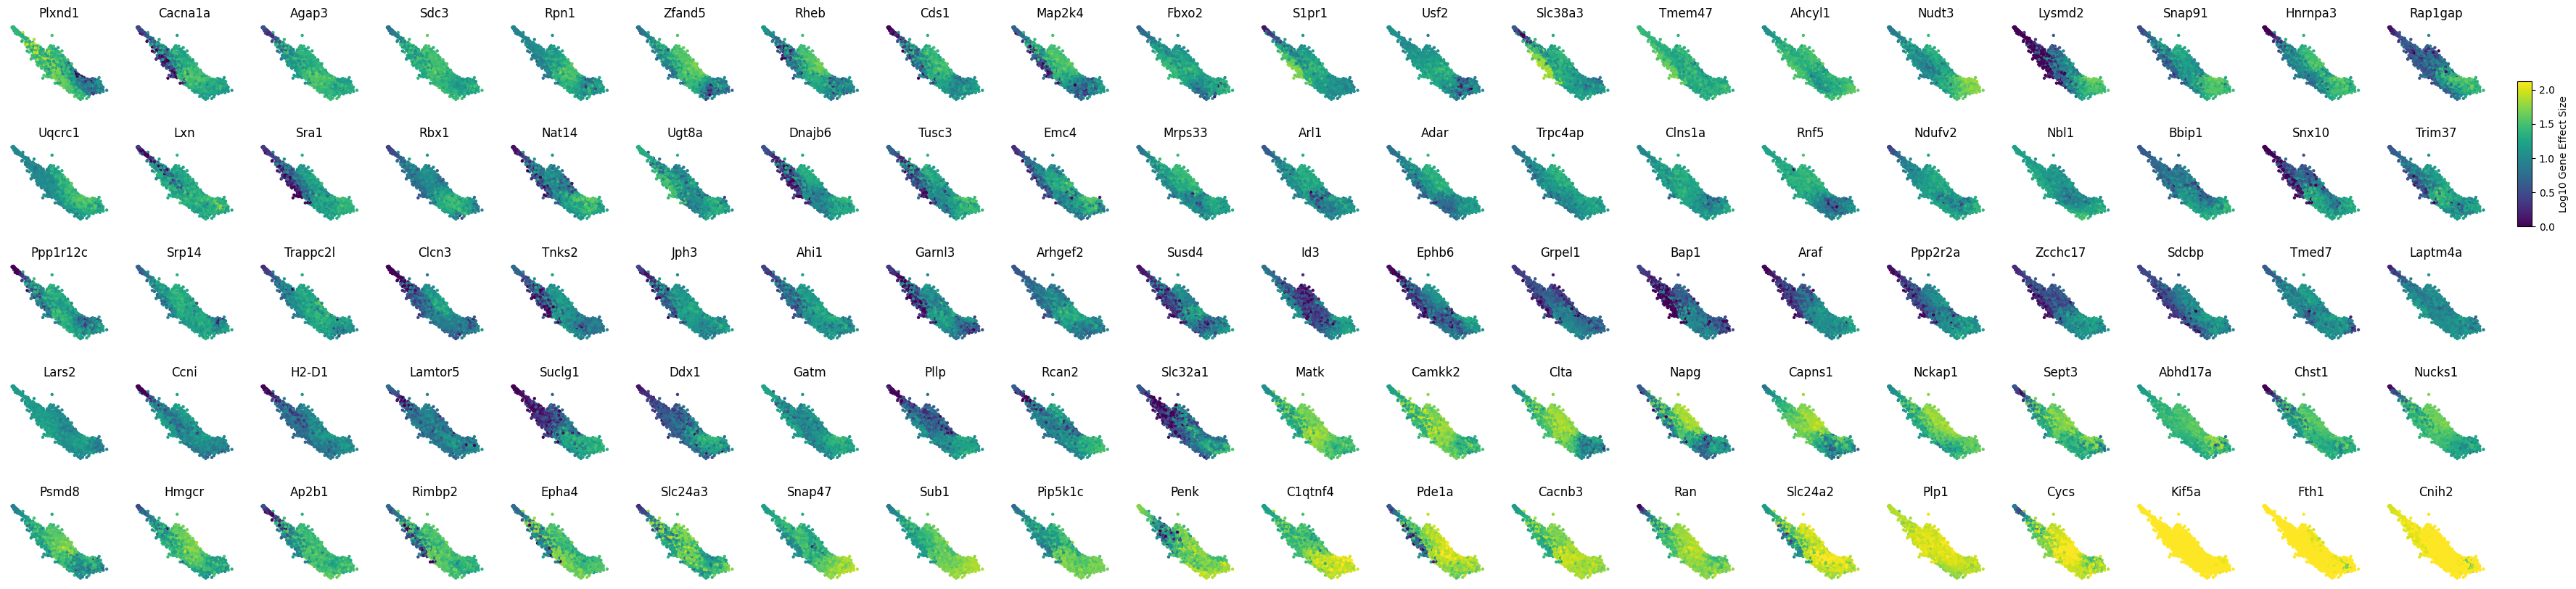

In [ ]:
# Choose genes
genes_to_show = perturbed_genes
np.random.seed(42)
genes_to_show = np.random.choice(genes_to_show, 100, replace=False)

# Dendogram Sorting
df = pd.DataFrame(index=genes_to_show, columns=adata_val.obs.index).astype(float)
df[:] = np.stack([effect_sizes[g] for g in genes_to_show], axis=0)
# Sort
dist = scipy.spatial.distance.pdist(df)
linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
genes_to_show = genes_to_show[ordered_leaves]

# Styling
cmap = sns.color_palette('viridis', as_cmap=True)
vmax = np.quantile(list(effect_sizes.values()), .98)
vmax = np.log10(np.quantile(list(effect_sizes.values()), .98))
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)

# Initialize
fig, axs = plt.subplots(5, np.ceil(len(genes_to_show)/5).astype(int), figsize=(40, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(right=.98)
axs = axs.flatten()
for ax, gene in zip(axs, genes_to_show):
    df = pd.DataFrame(index=adata_val.obs.index)
    df[['x', 'y']] = raw_coords
    df['Effect Size'] = effect_sizes[gene]
    df['Log10 Effect Size'] = np.log10(effect_sizes[gene])
    sns.scatterplot(df, x='x', y='y', s=10, edgecolor='none', hue='Log10 Effect Size', palette=cmap, hue_norm=norm, ax=ax, legend=False)
    sns.despine(bottom=True, left=True, ax=ax)
    # Remove grid
    ax.grid(False)
    ax.set(xticks=[], yticks=[], xlabel=None, ylabel=None)
    ax.set_title(gene)

# Add colorbar
ax_cbar = fig.add_axes([0.99, 0.6, 0.005, 0.2])
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             cax=ax_cbar, label='Log10 Gene Effect Size');